In [ ]:
## Add early stoping and reduceLROnPlatue 
## Parallelization for feature engineering import dask.dataframe as dd for rolling calculations 
## System level optimizations, reduce precision (float16), import multiprocessing import Pool, 

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.metrics import MeanAbsoluteError
from keras.optimizers import Adam

In [3]:
# Load ETF data
pair_data = pd.read_csv('Energy_ETF_price_data.csv', parse_dates=['Date'], index_col='Date')
commodities_data = pd.read_csv('comodities_data.csv', parse_dates=['Date'], index_col='Date')
commodities_data = commodities_data.reindex(pair_data.index).fillna(method='ffill')

# selected pair 
selected_pair = 'AMLP-EMLP'
etf1, etf2 = selected_pair.split('-')

# Define training and testing periods
training_start = '2019-01-01'
training_end = '2022-12-31'
testing_start = '2022-01-01'
testing_end = '2023-12-31'
trading_start = '2023-01-01'
trading_end = '2024-11-29'

/var/folders/_v/vfbxc80973l9zq3s4w559dzm0000gn/T/ipykernel_74530/1808463195.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  commodities_data = commodities_data.reindex(pair_data.index).fillna(method='ffill')


In [5]:
# training 
training_data = pair_data.loc[training_start:training_end][[f'{etf1}_adj_close', f'{etf2}_adj_close', f'{etf1}_volume', f'{etf2}_volume']].dropna()
training_data = pd.concat([training_data, commodities_data.loc[training_start:training_end]], axis=1).dropna()
training_data.columns = [etf1, etf2, f'{etf1}_volume', f'{etf2}_volume', 'Brent_Crude', 'WTI_Crude', 'Natural_Gas']

# testing
testing_data = pair_data.loc[testing_start:testing_end][[f'{etf1}_adj_close', f'{etf2}_adj_close', f'{etf1}_volume', f'{etf2}_volume']].dropna()
testing_data = pd.concat([testing_data, commodities_data.loc[testing_start:testing_end]], axis=1).dropna()
testing_data.columns = [etf1, etf2, f'{etf1}_volume', f'{etf2}_volume', 'Brent_Crude', 'WTI_Crude', 'Natural_Gas']

In [6]:
# Feature Engineering
def feature_engineering(data, scaler=None):
    data['Spread'] = data[etf1] - data[etf2]
    data['Volume'] = data[f'{etf1}_volume'] + data[f'{etf2}_volume']

    # Calculate On-Balance Volume (OBV)
    data['OBV'] = (data['Spread'].diff() > 0).astype(int) * data['Volume'] - (data['Spread'].diff() < 0).astype(int) * data['Volume']
    data['OBV'] = data['OBV'].cumsum()

    # Normalize the Spread feature
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(0, 1))
        data['Spread'] = scaler.fit_transform(data['Spread'].values.reshape(-1, 1))
    else:
        data['Spread'] = scaler.transform(data['Spread'].values.reshape(-1, 1))

    data['Price_Ratio'] = data[etf1] / data[etf2]
    data['5D_MA'] = data['Spread'].rolling(window=5).mean()
    data['10D_MA'] = data['Spread'].rolling(window=10).mean()
    data['Spread_STD'] = data['Spread'].rolling(window=10).std()

    # Relative Strength Index (RSI)
    def calculate_rsi(series, period=14):
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    data['RSI'] = calculate_rsi(data['Spread'])

    # Moving Average Convergence Divergence (MACD)
    ema_12 = data['Spread'].ewm(span=12, adjust=False).mean()
    ema_26 = data['Spread'].ewm(span=26, adjust=False).mean()
    data['MACD'] = ema_12 - ema_26

    # Lagged Features
    data['Lag_1'] = data['Spread'].shift(1)
    data['Lag_2'] = data['Spread'].shift(2)

    # Logarithm of commodities prices
    data['Brent_Crude_log'] = np.log(data['Brent_Crude'])
    data['WTI_Crude_log'] = np.log(data['WTI_Crude'])
    data['Natural_Gas_log'] = np.log(data['Natural_Gas'])

    return data.dropna(), scaler

In [7]:
# Apply feature engineering to both training and testing data
training_data, spread_scaler = feature_engineering(training_data)
testing_data, _ = feature_engineering(testing_data, spread_scaler)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
# Feature Selection
features = ['Spread', 'Price_Ratio', '5D_MA', '10D_MA', 'Spread_STD', 'RSI', 'MACD', 'Lag_1', 'Lag_2', 'OBV', 'Brent_Crude_log', 'WTI_Crude_log', 'Natural_Gas_log']
X_train = training_data[features]
y_train = training_data['Spread']

X_test = testing_data[features]
y_test = testing_data['Spread']

# Calculate feature importance using MDI with RandomForestRegressor
forest = RandomForestRegressor(n_estimators=200, random_state=42)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print("Feature Importances (MDI):")
print(feature_importance_df)

Feature Importances (MDI):
            Feature  Importance
0            Spread    0.947983
1       Price_Ratio    0.051841
8             Lag_2    0.000074
7             Lag_1    0.000029
2             5D_MA    0.000013
10  Brent_Crude_log    0.000013
11    WTI_Crude_log    0.000009
9               OBV    0.000007
5               RSI    0.000007
4        Spread_STD    0.000007
12  Natural_Gas_log    0.000006
6              MACD    0.000006
3            10D_MA    0.000005


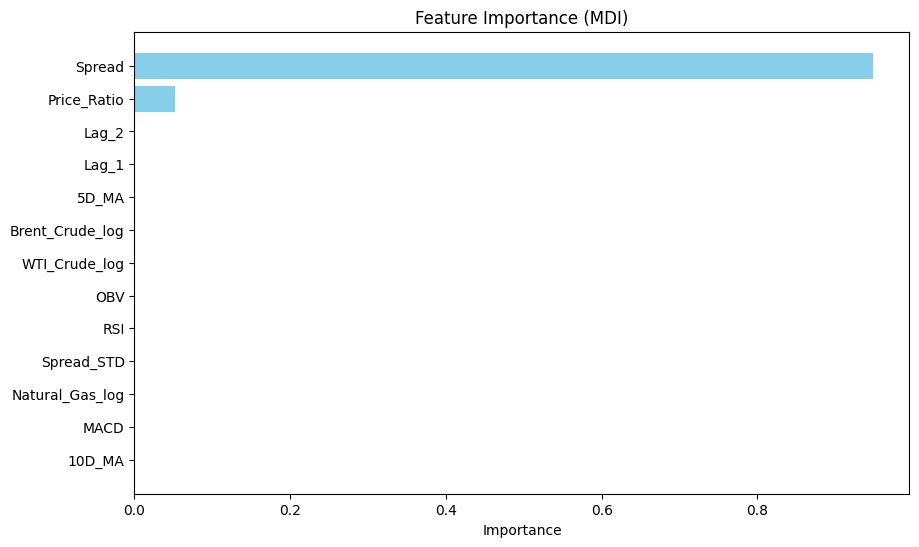

In [9]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance (MDI)')
plt.gca().invert_yaxis()
plt.show()

In [10]:
# Select important features
important_features = feature_importance_df[feature_importance_df['Importance'] > 0.001]['Feature'].tolist()
X_train = X_train[important_features]
X_test = X_test[important_features]

In [11]:
# Create sequences for LSTM
# def create_sequences(data_X, data_y, time_step):
#     X_seq, y_seq = [], []
#     for i in range(len(data_X) - time_step):
#         X_seq.append(data_X.iloc[i:(i + time_step)].values)
#         # Predict the next day's spread after the last day in the sequence
#         y_seq.append(data_y.iloc[i + time_step])
#     return np.array(X_seq), np.array(y_seq)
def create_sequences(data_X, data_y, time_step):
    X_seq = np.array([data_X.iloc[i:i + time_step].values for i in range(len(data_X) - time_step)])
    y_seq = np.array([data_y.iloc[i + time_step] for i in range(len(data_y) - time_step)])
    return X_seq, y_seq

In [24]:
# Use a 30-day lookback
time_step = 5
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_step)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_step)

In [13]:
# Rolling/Walk-Forward Validation to avoid look-ahead bias
def rolling_training(X_seq, y_seq, model, batch_size=128, epochs=10, step_size=10):
    predictions = []
    true_values = []

    for i in range(0, len(X_seq) - step_size, step_size):
        X_train = X_seq[:i + step_size]
        y_train = y_seq[:i + step_size]
        
        if len(X_train) < step_size:
            continue

        X_test = X_seq[i + step_size:i + step_size + 1]
        y_test = y_seq[i + step_size:i + step_size + 1]
        
        if len(X_test) == 0:
            break

        # Train model
        model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)

        # Predict next point
        pred = model.predict(X_test)
        predictions.append(pred[0][0])
        true_values.append(y_test[0])

    return predictions, true_values

In [ ]:
training_data.to_csv('processed_training_data.csv', index=False)

In [15]:
# Define LSTM Model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]), kernel_regularizer=l2(0.001), activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001), activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='huber', metrics=[MeanAbsoluteError()])

In [16]:
# Perform Rolling/Walk-Forward Validation
predictions, true_values = rolling_training(X_train_seq, y_train_seq, model, batch_size=32, epochs=50, step_size=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━

In [ ]:
# Evaluate the predictions
predicted_spreads = spread_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
true_spreads = spread_scaler.inverse_transform(np.array(true_values).reshape(-1, 1))

In [19]:
print("Predictions:", predictions)
print("True Values:", true_values)


Predictions: [0.4580189, 0.9301692, 0.8239993, 0.83127254, 0.8432444, 0.8797626, 0.90317047, 0.91376543, 0.92256486, 0.9336544, 0.9371791, 0.9429327, 0.9457175, 0.94005394, 0.94302434, 0.94370264, 0.9427872, 0.942415, 0.9440384, 0.9410363, 0.9447862, 0.9457797, 0.9461137, 0.9471539, 0.94671535, 0.94686913, 0.9452258, 0.9466262, 0.94697845, 0.9470168, 0.9464793, 0.9466042, 0.95593536, 0.94315296, 0.93975544, 0.9488709, 0.94344676, 0.945799, 0.94992113, 0.9506852, 0.9508672, 0.9421892, 0.94557923, 0.9439499, 0.94708127, 0.94043434, 0.94267064, 0.9449028, 0.94082254, 0.9434973, 0.94329596, 0.94629776, 0.94573027, 0.9445952, 0.9409919, 0.94552857, 0.9425131, 0.9450757, 0.9427458, 0.94008857, 0.94324815, 0.9425353, 0.9416666, 0.9428241, 0.9497515, 0.9373319, 0.9361743, 0.9414804, 0.9425577, 0.93744934, 0.9394599, 0.9387517, 0.93450993, 0.9281402, 0.93967456, 0.9341321, 0.9355471, 0.936147, 0.93687946, 0.93317574, 0.93583393, 0.9360628, 0.93242633, 0.9305247, 0.93502045, 0.9327593, 0.9297645

In [21]:
if not predictions or not true_values:
    print("Error: Predictions or true values are empty.")

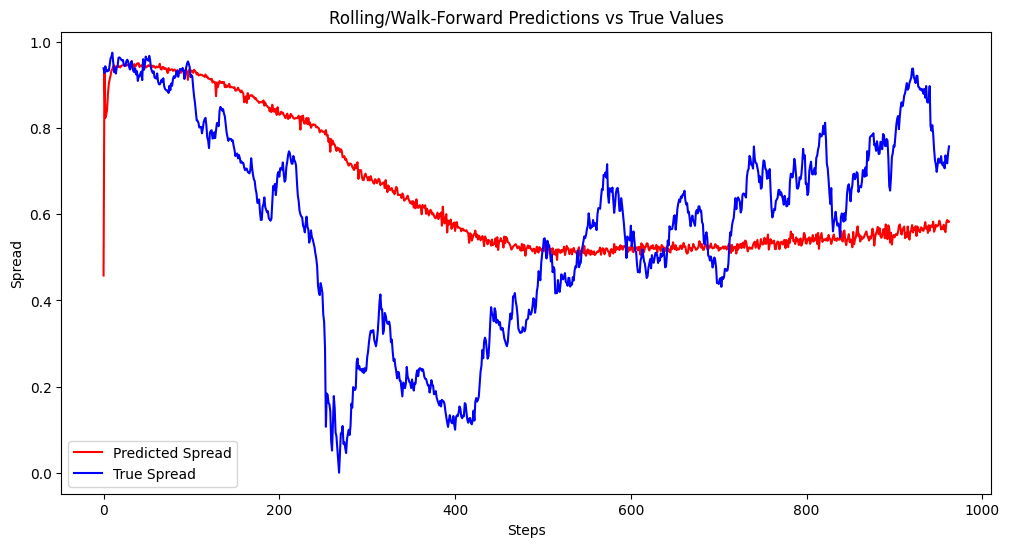

In [23]:
# Plot Predictions vs True Values
plt.figure(figsize=(12, 6))
plt.plot(predictions, label='Predicted Spread', color='red')
plt.plot(true_values, label='True Spread', color='blue')
plt.title('Rolling/Walk-Forward Predictions vs True Values')
plt.xlabel('Steps')
plt.ylabel('Spread')
plt.legend()
plt.show()

In [ ]:
# Save Rolling Predictions
predictions_df = pd.DataFrame({'Predicted_Spread': predicted_spreads.flatten(), 'True_Spread': true_spreads.flatten()})
predictions_df.to_csv('rolling_predictions.csv', index=False)

print("Shape of predicted_spreads:", predicted_spreads.shape)
print("Shape of true_spreads:", true_spreads.shape)

In [25]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16176836803359559312
xla_global_id: -1
]
